<a href="https://colab.research.google.com/github/Alexandre0702/TER-SO-Suicide/blob/main/Travail_visualisations_Spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***TER SO'Suicide***



# **Goal** : **Build a Knowledge Graph from Text Data**
Following the article of PRATEEK JOSHI, OCTOBER 14, 2019: <br/> https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

## Importation of libraries and read data

In [1]:
#importation of the prerequisit libraries
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [9]:
#importation of data : wikipedia sentences
# CSV free to download via : https://drive.google.com/file/d/1yuEUhkVFIYfMVfpA_crFGfSeJLgbPUxu/view
candidate_sentences = pd.read_csv("https://drive.google.com/u/0/uc?id=1yuEUhkVFIYfMVfpA_crFGfSeJLgbPUxu&export=download")
candidate_sentences.shape

(4318, 1)

In [21]:
# Let's have a look on the data
candidate_sentences['sentence'].sample(5)

2097                                                        this movie was also an example of political commentary.
1723                                  at this time, lavish romantic musicals and melodramas were cinematic staples.
3593    cube is a 1997 canadian independent science-fiction horror film directed and co-written by vincenzo natali.
3526                             the cast was headed by vanessa redgrave, sarah miles, diana dors and brenda bruce.
1082                                                                                     it was introduced in 1963.
Name: sentence, dtype: object

## Small Analyses using Spacy

### Entity Pairs Extraction

In [13]:
#We pick one of these sentences
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


We see here that every entity in the sentence in splited by words. We woud like to obtain the same idea of analysis, but using the entire entity and its function in the sentence. Exemple: getting "astm standard d823" instead of each word separated.

In [14]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [19]:
print(get_entities("the film had 200 patents"))
print(get_entities("the drawdown process is governed by astm standard d823"))

['film', '200  patents']
['drawdown  process', 'astm standard astm d823']


In [22]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))


100%|██████████| 4318/4318 [00:44<00:00, 97.09it/s]


> The list *entity_pairs* contains all the subject-object pairs from the Wikipedia sentences. Let’s have a look at a few of them:

In [23]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

### Relation / Predicate Extraction

*The hypothesis is that the predicate is actually the main verb in a sentence.*

In [24]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [25]:
get_relation("John completed the task")

'completed'

In [26]:
get_relation("the drawdown process is governed by astm standard d823")

'governed by'

In [27]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:48<00:00, 88.76it/s] 


In [28]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
were              71
are               71
released          40
's                38
composed by       35
has               31
have              31
became            31
become            29
released in       27
included          26
called            22
produced          22
had               20
considered        20
made              20
been              18
be                18
scheduled         17
used              17
stars             16
directed by       16
written by        15
hired             14
wrote             14
produced by       14
set               14
introduced in     13
went              13
received          13
wanted            12
began in          11
began             11
won               11
sold              10
features          10
gave              10
opened             9
reported           9
shot in            9
known as           9
includes           9
used in            9
gives        

## Build a Knowledge Graph

In [29]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

To get a directed graph:

In [30]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

Plotting the network:

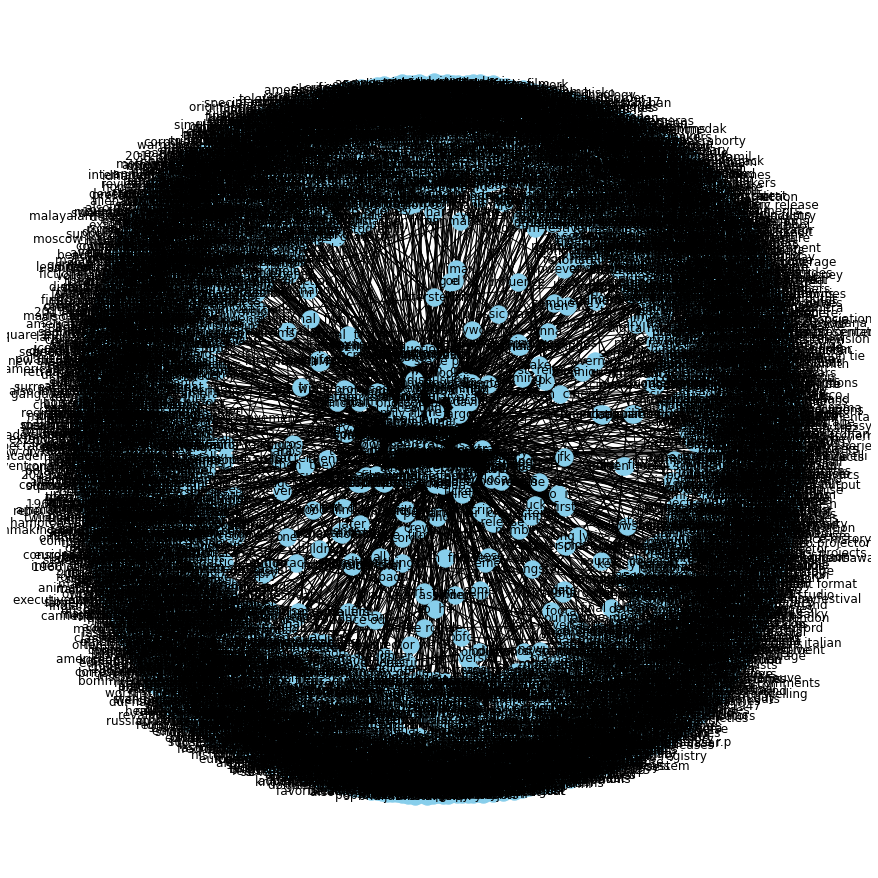

In [32]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Let's extract few relations to see what's happening there..

### The relation “*composed by*”:

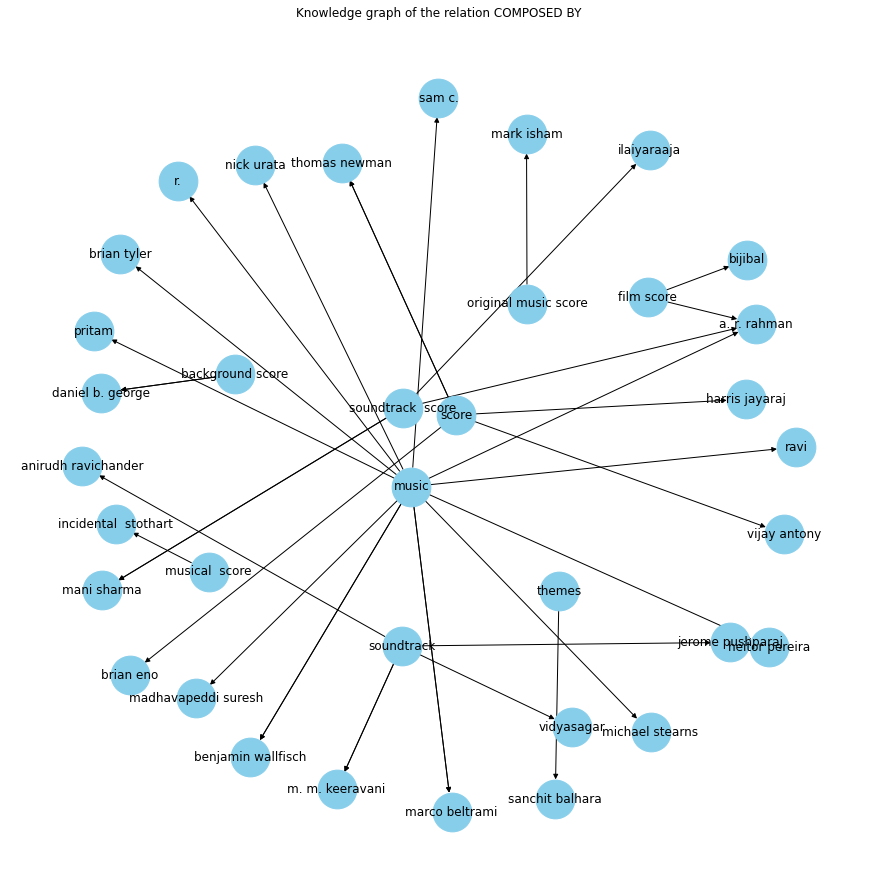

In [38]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title("Knowledge graph of the relation COMPOSED BY")
plt.show()

### The relation "*written by*"

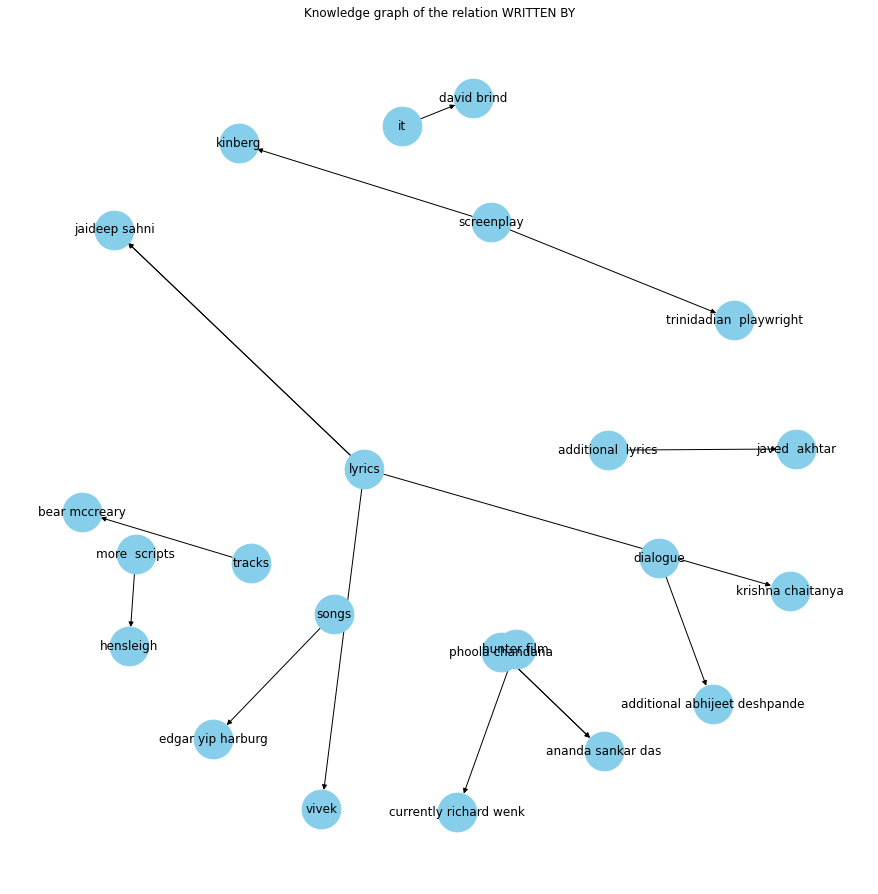

In [37]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title("Knowledge graph of the relation WRITTEN BY")
plt.show()

### The relation "*released in*" :

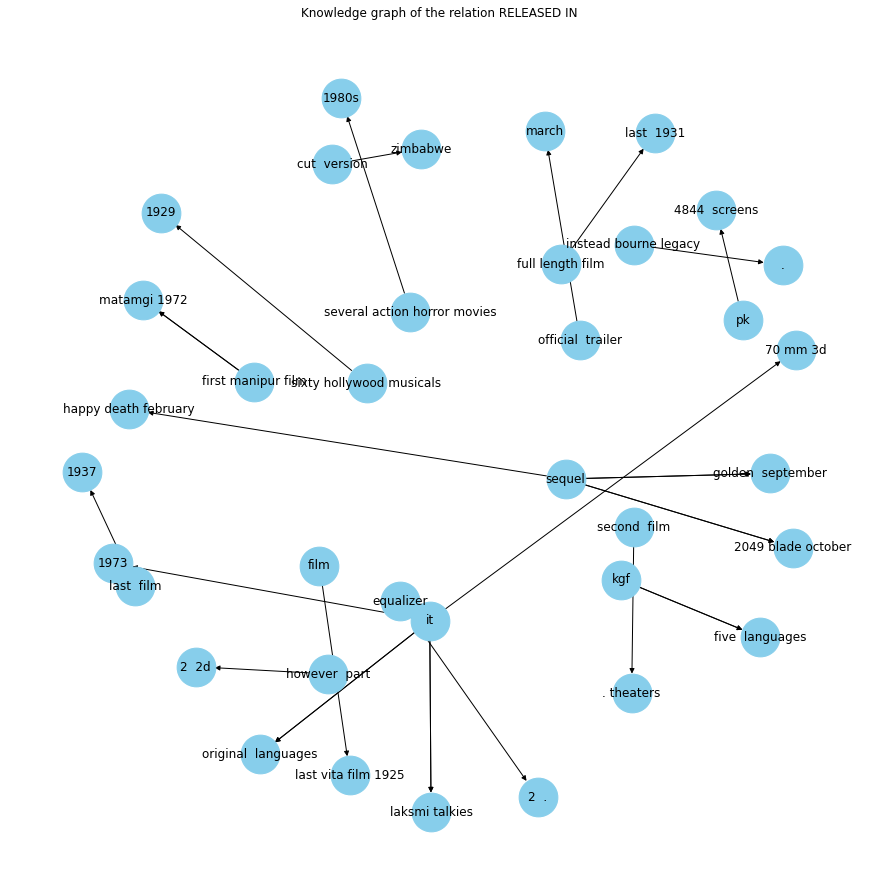

In [36]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.title("Knowledge graph of the relation RELEASED IN")
plt.show()